### Fetal Classification ###
#### This dataset contains 2126 records of features extracted from Cardiotocogram(CTG) exams of to be born fetuses, which were then classified by three expert obstetritians into 3 classes: ####
1.Normal
2.Suspect
3.Pathological

***Short Medical Background:***    
1.*The normal fetal heart beat rate has a value ranging from __110 to 160 beats per min__.*   
2.*Some of the CTG features indicate good fetal health and others indicate a negative effect, leading to the fetal health classified as 'Pathological'*   
3.*Hence, the positive class in this multiclass problem would be 'Class 3: Pathological'*   
#### Citation: _Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318_ https://onlinelibrary.wiley.com/doi/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9
### Objective: ###
#### The objective of the current analysis is to create a multiclassifier model to classify the CTG features into the three fetal health states, using various models like Logistic Regression, KNN, Random Forest, Gradientboosting and XGboost and see which one performs the best ####   

In [1]:
import numpy as np, os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import math
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler, PowerTransformer

from imblearn.over_sampling import RandomOverSampler

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Reading the files

In [3]:
#Read files:
path = 'fetal_health.csv'
data = pd.read_csv(path)

### Preprocessing and Data Cleaning ###

In [4]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
data.shape

(2126, 22)

In [6]:
data['fetal_health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

> This shows that our target ***'fetal_health'*** is unbalanced, with 78% of the observations being class 1(Normal), 14% for class 2(Suspect) and only 8% for class 3(Pathological) 

In [7]:
data.info(verbose = True, show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

> *__This shows that there are no missing values__*

**The columns with names starting with 'histogram_' do not appear as the features of a CTG exam and hence for simplification purposes, won't be considered for the analysis here.**

In [8]:
data_bk = data.copy()

In [9]:
for col in data.columns:
    if 'histogram' in col:
        data.drop(columns=col, inplace=True)

In [10]:
data.shape

(2126, 12)

In [11]:
data.rename(columns={'abnormal_short_term_variability':'%_time_with_abnormal_short_term_variability','baseline value':'FHR_baseline_value'},inplace=True)
data.rename(columns={'percentage_of_time_with_abnormal_long_term_variability':'%_time_with_abnormal_long_term_variability'},inplace=True)

> Renaming some of the columns for more comprehensibility

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
FHR_baseline_value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
%_time_with_abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
%_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


> From the statistical overview, one can see that the features like __'severe_decelerations', 'prolongued_decelerations', '%time_with_abnormal_long_term_variability'__ have 1. very small values and are 2. highly skewed.   
> These features will be seen in a bit more detail in EDA

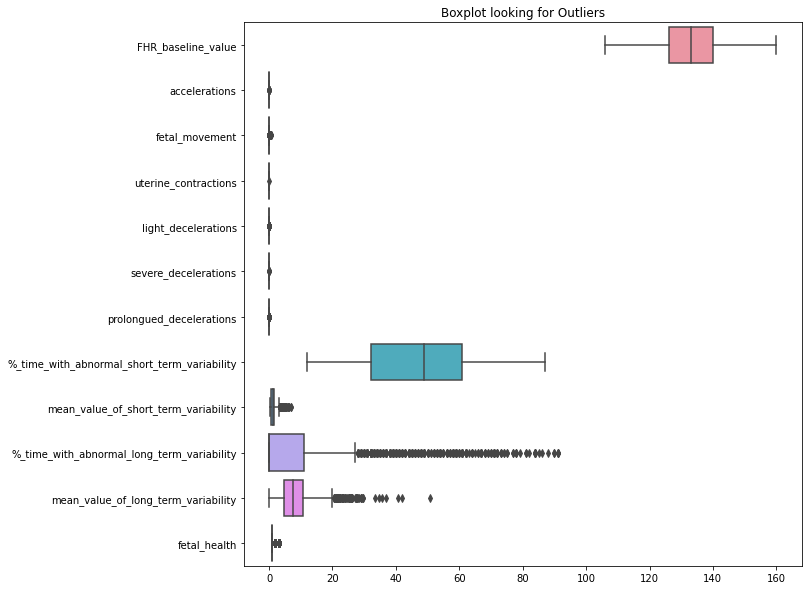

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(data = data, orient='h')
ax.set_title('Boxplot looking for Outliers');

> *It could be inferred here that the features like __'%_time_with_abnormal_long_term_variability'__, __'mean_value_of_long_term_variability'__ have many outliers. But actually their max. values are not very high in scale as compared to the 75th percentile value.*  

> *Also, these feature will have a high negative correlation with the target variable 'fetal_health'(as would be seen in the below sections) and hence would be critical to the analysis.*    
> *Hence these will not be dealt with.*

> *Since there are no categorical columns, we dont need one-hot encoding*

### Exploratory Data Analysis ###

#### Correlation of features: ####
> *Some of the features have a majority of values equal to '0' or very small. Lets have a look*

In [14]:
data['fetal_movement'].value_counts()

0.000    1311
0.001     164
0.002     112
0.003      88
0.004      49
         ... 
0.481       1
0.425       1
0.360       1
0.115       1
0.063       1
Name: fetal_movement, Length: 102, dtype: int64

In [15]:
data['severe_decelerations'].value_counts()

0.000    2119
0.001       7
Name: severe_decelerations, dtype: int64

In [16]:
data['prolongued_decelerations'].value_counts()

0.000    1948
0.002      72
0.001      70
0.003      24
0.004       9
0.005       3
Name: prolongued_decelerations, dtype: int64

In [17]:
data['light_decelerations'].value_counts()

0.000    1231
0.001     163
0.003     118
0.002     115
0.004     114
0.005     107
0.006      74
0.008      55
0.007      54
0.009      37
0.010      15
0.011      13
0.012      12
0.013       8
0.014       7
0.015       3
Name: light_decelerations, dtype: int64

In [18]:
y = data.fetal_health
feature_cols = list(data.columns[:-1])   ## store all columns except the last column
correlations = data[feature_cols].corrwith(y)
correlations.sort_values(inplace=True)
correlations

accelerations                                 -0.364066
mean_value_of_long_term_variability           -0.226797
uterine_contractions                          -0.204894
mean_value_of_short_term_variability          -0.103382
light_decelerations                            0.058870
fetal_movement                                 0.088010
severe_decelerations                           0.131934
FHR_baseline_value                             0.148151
%_time_with_abnormal_long_term_variability     0.426146
%_time_with_abnormal_short_term_variability    0.471191
prolongued_decelerations                       0.484859
dtype: float64

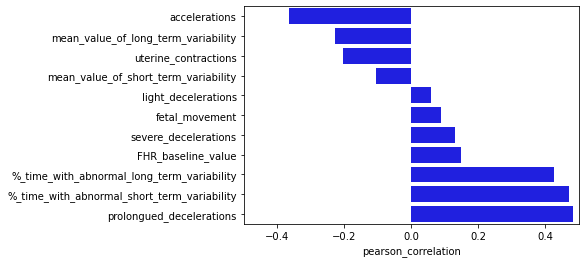

In [19]:
# Plot the correlations with a bar graph
ax = sns.barplot(x = correlations.values, y = correlations.index, color='blue')
ax.set(xlim=[-0.5,0.5], xlabel='pearson_correlation');

1.*The plot shows the correlation with the fetal_health class. A positive correlation means that the feature causes a higher class(in this case, class 3, which is __'Pathological'__ or worrisome) and a negative correlation means a lower class(class 1 or 2, __'Normal'__ or __'Suspect'__ ).*   
   
2.*The features which were seen above having very small values close to '0', have a __negative effect on 'fetal_health' (majorly Class 3,'Pathological')__. Now because the dataset is imbalanced with only __176 Class 3__ and __295 Class 2__ samples, it makes only sense that these features have zero values for __Normal__ class and non-zero values only for these other two classes which are very less in number.*     

3.*Hence these zero values would be considered for the analysis*

#### Heatmap ####

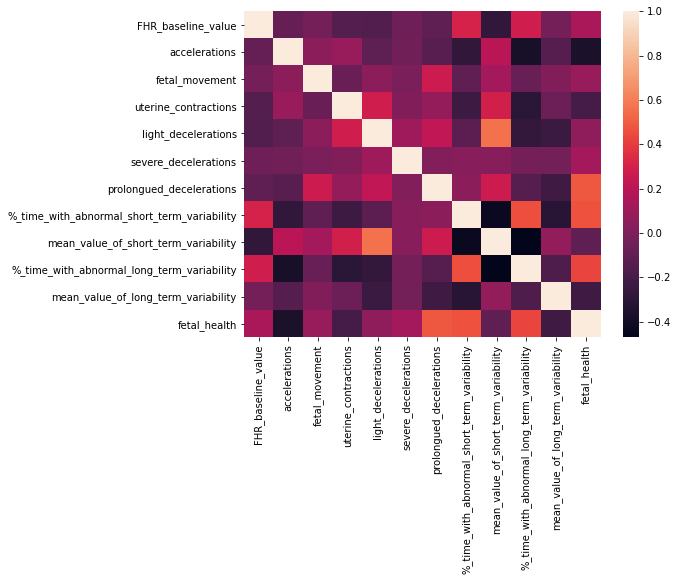

In [20]:
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(data.corr());

### Feature Engineering ###   
#### Skewness: ####

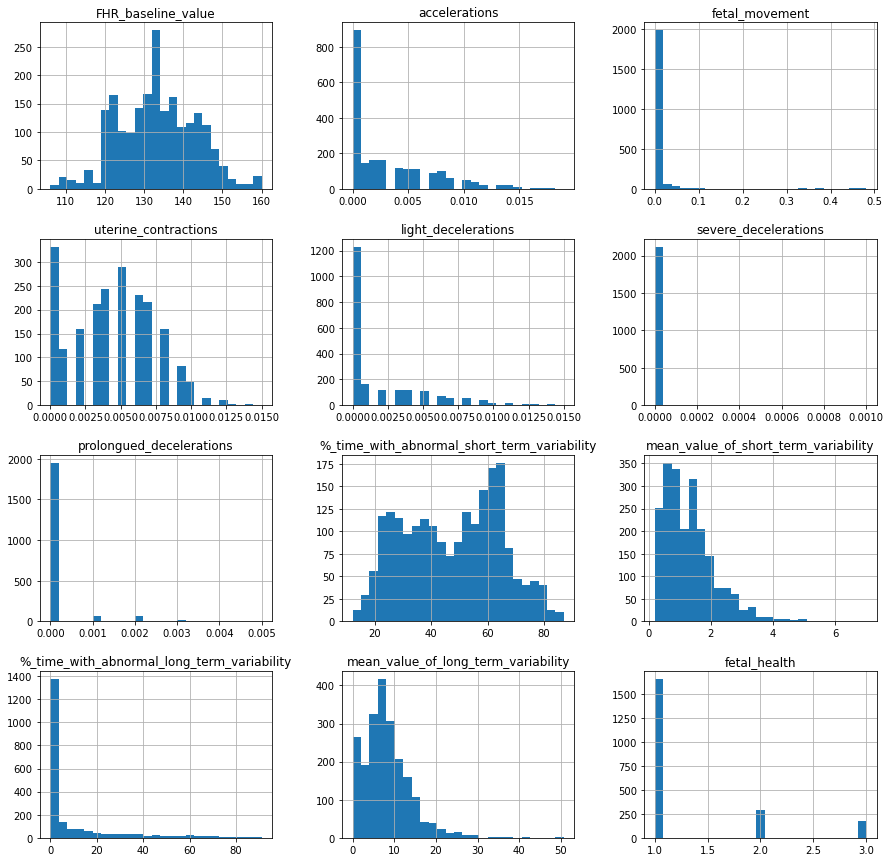

In [21]:
data.hist(bins=25, figsize=(15,15));

#### Measuring the skewness ####

In [22]:
feature_cols = data.columns[:-1]
skew_limit = 0.75
skew_vals = data[feature_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))
skew_cols

,Skew
severe_decelerations,17.353457
fetal_movement,7.811477
prolongued_decelerations,4.323965
%_time_with_abnormal_long_term_variability,2.195075
light_decelerations,1.718437
mean_value_of_short_term_variability,1.657339
mean_value_of_long_term_variability,1.331998
accelerations,1.204392


> **One can see that again from the histogram that the features having many '0' values make the data highly skewed. But as discussed in the previous section, this skewness occurs because of the high imbalance in the data, and hence is considered normal.** 

> **This can also be seen from the scatter plot below for every feature vs the fetal heart beat rate, where the skewed features with extreme low values are for the 'Normal' class 1 and the higher sporadic values are for the 'Pathological' Class 3.**

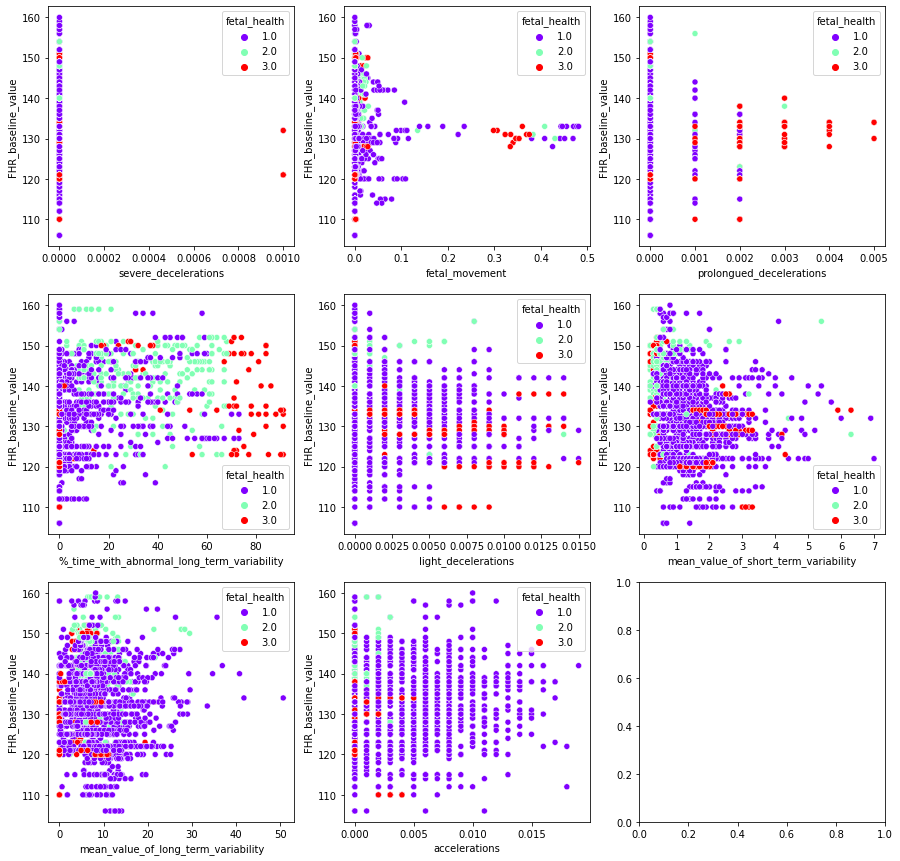

In [23]:
nrows=3
ncols=3
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for i,col in enumerate(skew_cols.index):
    sns.scatterplot(data=data, x = data[col],y= data['FHR_baseline_value'],hue= data['fetal_health'],ax=axes[i//ncols, i%ncols],palette='rainbow')

### Classification Models ###   
#### Following Classification Models will be used to train and test the data here ####

1. Logistic Regression with l1 penalty
2. Logistic Regression with l2 penalty
2. KNN
3. Random forest
4. Gradient Boosting
5. XGBoost

#### Splitting the data ####

In [24]:
#Get the Split indices
def strat_shuff_split():
    splitxy = StratifiedShuffleSplit(n_splits =1, test_size=0.3, random_state=42)
    
    train_idx, test_idx = next(splitxy.split(data[feature_cols],data.fetal_health))## next() converts the generator object to an array 
    
    #Create the dataframes
    x_train = data.loc[train_idx, feature_cols]
    y_train = data.loc[train_idx, 'fetal_health']
    x_test = data.loc[test_idx, feature_cols]
    y_test = data.loc[test_idx, 'fetal_health']
    return x_train,x_test,y_train,y_test

In [25]:
x_train,x_test,y_train,y_test = strat_shuff_split()

In [26]:
y_train.value_counts(normalize=True)

1.0    0.778226
2.0    0.139113
3.0    0.082661
Name: fetal_health, dtype: float64

In [27]:
y_test.value_counts(normalize=True)

1.0    0.778997
2.0    0.137931
3.0    0.083072
Name: fetal_health, dtype: float64

> *Ensuring the train and test data are also imbalanced*

#### Defining the Models ####

In [28]:
models = []
models.append(('Logistic Regression with l1 penalty',LogisticRegressionCV(Cs=10, cv=5, penalty='l1',
                                                                          solver='liblinear',class_weight='balanced',
                                                                          random_state= 42)))
models.append(('Logistic Regression with l2 penalty',LogisticRegressionCV(Cs=10, cv=5, penalty='l2',
                                                                          solver='liblinear',class_weight='balanced',
                                                                          random_state= 42)))
models.append(('Random Forest with Entropy', RandomForestClassifier(n_estimators=100, criterion= "entropy",
                                                                    warm_start=True, n_jobs=-1, random_state= 42)))
models.append(('Random Forest with gini', RandomForestClassifier(n_estimators=100, criterion= "gini",
                                                                 warm_start=True, n_jobs=-1, random_state= 42)))
models.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators=100,learning_rate =0.01,
                                                              subsample=1, criterion='friedman_mse', random_state=42)))
models.append(('XGBoost', XGBClassifier(n_estimators=100,seed=7, eval_metric='mlogloss',learning_rate=0.1,max_depth=500, 
                                       subsample=1, n_jobs=-1, random_state=42)))

#### Evaluation Metric : ####
> Since one is dealing here with the fetal_health, it is critical that as many of the Actual positives 'class 3/Pathological' cases be predicted as True positive as possible, while minimizing the False negatives. Hence __'Recall'__ would be the choice of metric here for evaluation

**User-defined functions:**

> Here a function would be created to combine all the models except KNN, to do the prediction.   
> Since *'KNN' is the only method among the classifiers which works better with scaling, it will be run after the function*

In [29]:
def scores_(name,y_pred, y_prob, target_names):        
    print(name,':\n')
    print(classification_report(y_test, y_pred, target_names = target_names))
    precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovr')
    accuracy = accuracy_score(y_test, y_pred)
    return precision, recall, fscore, roc_auc, accuracy

In [30]:
def classifiers():    # Function returns a Dataframe with the different models and their error metrics
    row=0
    target_names = ['class 1','class 2','class 3']
    clfmodels = pd.DataFrame(columns=['Model','Recall','Precision','F1-score','roc_auc_score','Accuracy'])
    for name,model in models:
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)
        #Precision, recall, f_score using multi-class support function
        precision, recall, fscore, roc_auc, accuracy = scores_(name,y_pred, y_prob, target_names)
        clfmodels.loc[row,'Model'] = name
        clfmodels.loc[row,'Recall'] = round(recall,2)
        clfmodels.loc[row,'Precision'] = round(precision,2) 
        clfmodels.loc[row,'F1-score'] = round(fscore,2) 
        clfmodels.loc[row,'roc_auc_score'] = round(roc_auc,2) 
        clfmodels.loc[row,'Accuracy'] = round(accuracy,2)
        row +=1
    return clfmodels

In [31]:
clfmodels = classifiers()
clfmodels.sort_values(by = 'Recall', ascending = False)

Logistic Regression with l1 penalty :

              precision    recall  f1-score   support

     class 1       0.97      0.82      0.89       497
     class 2       0.43      0.72      0.54        88
     class 3       0.60      0.79      0.68        53

    accuracy                           0.81       638
   macro avg       0.67      0.78      0.70       638
weighted avg       0.87      0.81      0.82       638

Logistic Regression with l2 penalty :

              precision    recall  f1-score   support

     class 1       0.96      0.77      0.85       497
     class 2       0.46      0.82      0.59        88
     class 3       0.37      0.57      0.45        53

    accuracy                           0.76       638
   macro avg       0.60      0.72      0.63       638
weighted avg       0.84      0.76      0.78       638

Random Forest with Entropy :

              precision    recall  f1-score   support

     class 1       0.94      0.98      0.96       497
     class 2       0.

,Model,Recall,Precision,F1-score,roc_auc_score,Accuracy
2,Random Forest with Entropy,0.93,0.93,0.93,0.98,0.93
3,Random Forest with gini,0.93,0.93,0.93,0.98,0.93
5,XGBoost,0.93,0.93,0.93,0.98,0.93
4,Gradient Boosting,0.91,0.91,0.9,0.94,0.91
0,Logistic Regression with l1 penalty,0.81,0.87,0.82,0.94,0.81
1,Logistic Regression with l2 penalty,0.76,0.84,0.78,0.9,0.76


> From __Recall__ perspective one can see that XGboost gets the highest score of __0.92__ for __Class 3__. For the average weighted recall scores, XGboost and Random forest achieve equal scores of 0.93. Logistic with 'l2 penalty' performs the worst. Hence one can already have an idea of the best models here.   

> The recall values for __class 3__ for each model would be mainly taken into consideration as that is the minority class.

In [32]:
def KNN_():
    mm = MinMaxScaler()
    x_tr = mm.fit_transform(x_train)
    x_ts = mm.fit_transform(x_test)
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn = knn.fit(x_tr, y_train)
    y_pred = knn.predict(x_ts)
    y_prob = knn.predict_proba(x_ts)
    return scores_('KNN',y_pred,y_prob,target_names = ['class 1','class 2','class 3'])

In [33]:
precision, recall, fscore, roc_auc, accuracy = KNN_()
print('recall',round(recall,3))
print('precision',round(precision,3))
print('fscore',round(fscore,3))
print('roc_auc_score',round(roc_auc,3))
print('accuracy',round(accuracy,3))

KNN :

              precision    recall  f1-score   support

     class 1       0.94      0.95      0.94       497
     class 2       0.66      0.68      0.67        88
     class 3       0.89      0.79      0.84        53

    accuracy                           0.90       638
   macro avg       0.83      0.81      0.82       638
weighted avg       0.90      0.90      0.90       638

recall 0.898
precision 0.899
fscore 0.898
roc_auc_score 0.932
accuracy 0.898


> It can be seen that KNN performs just slightly better than only Logistic Regression in terms of __Recall__ and other metrics

### Class Balancing:
Although the XGboost model already gives an impressive __Recall value__ = __0.92__ for __class 3__ on the imbalanced data set, oversampling would be tried to see if further improves the results. The label is imbalanced with an approx. 1:10 distribution(class 3 : class 1)

In [34]:
data['fetal_health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [35]:
sm = RandomOverSampler(random_state=42)
datax, datay = sm.fit_resample(data.iloc[:,:-1], data['fetal_health'])
print('Resampled dataset shape {}'.format(datay.value_counts()))

Resampled dataset shape 1.0    1655
2.0    1655
3.0    1655
Name: fetal_health, dtype: int64


In [36]:
# converting to a new dataframe
dataRsm = pd.DataFrame(datax,columns=data.iloc[:,:-1].columns.values)
dataRsm.head()

,FHR_baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,%_time_with_abnormal_short_term_variability,mean_value_of_short_term_variability,%_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9


In [37]:
# defining the new training and test sets
x_train, x_test, y_train, y_test = train_test_split(dataRsm, datay, test_size=0.30, random_state=42,shuffle=True)

In [38]:
classifiers().sort_values(by = 'Recall', ascending = False)

Logistic Regression with l1 penalty :

              precision    recall  f1-score   support

     class 1       0.90      0.83      0.86       520
     class 2       0.73      0.79      0.76       485
     class 3       0.83      0.84      0.83       485

    accuracy                           0.82      1490
   macro avg       0.82      0.82      0.82      1490
weighted avg       0.82      0.82      0.82      1490

Logistic Regression with l2 penalty :

              precision    recall  f1-score   support

     class 1       0.82      0.76      0.79       520
     class 2       0.74      0.82      0.78       485
     class 3       0.77      0.76      0.77       485

    accuracy                           0.78      1490
   macro avg       0.78      0.78      0.78      1490
weighted avg       0.78      0.78      0.78      1490

Random Forest with Entropy :

              precision    recall  f1-score   support

     class 1       0.90      1.00      0.95       520
     class 2       0.

,Model,Recall,Precision,F1-score,roc_auc_score,Accuracy
5,XGBoost,0.98,0.98,0.98,1.0,0.98
2,Random Forest with Entropy,0.96,0.96,0.96,1.0,0.96
3,Random Forest with gini,0.95,0.96,0.95,1.0,0.95
4,Gradient Boosting,0.9,0.9,0.9,0.98,0.9
0,Logistic Regression with l1 penalty,0.82,0.82,0.82,0.94,0.82
1,Logistic Regression with l2 penalty,0.78,0.78,0.78,0.9,0.78


> It can be seen that there is a substantial increase in the __Recall__ and other metrics with the data set becoming balanced. __XGboost__ gives the best recall of 0.98 and a perfect __roc_auc_score__ of 1.  

> However there seems to be a tendential overfitting here as due to the fact that there might be some data leakage in doing Oversampling before the train test split.   

> __Due to technical Issues with Xgboost package for generating an API__, *Hypertuning on Random Forest with Entropy* would be done, because that is the next best model. Only the original imbalanced data set would be used.

### Hypertuning :

In [39]:
x_train,x_test,y_train,y_test = strat_shuff_split()

In [40]:
ssf = StratifiedShuffleSplit(n_splits = 5, test_size=0.3, random_state=42)
param_test = {'max_features':['auto','sqrt'],
              'max_depth':[None,3,5,8],
              'min_samples_split':[1,2],
              'n_estimators':[30,50,100,150,200,300],
              'class_weight':['balanced','balanced_subsample']
             }
model = RandomForestClassifier(criterion= "entropy",warm_start=True, n_jobs=-1, random_state= 42)
grid_rf = GridSearchCV(model, param_grid=param_test, cv=ssf)
grid_rf.fit(x_train, y_train)
y_pred = grid_rf.predict(x_test) 
y_prob = grid_rf.predict_proba(x_test)

In [41]:
grid_rf.best_score_

0.9324384787472036

In [42]:
best_results = pd.DataFrame(grid_rf.cv_results_)
best_results.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
119,0.261202,0.004792,0.057198,0.002924,balanced_subsample,None,sqrt,2,300,"{'class_weight': 'balanced_subsample', 'max_de...",0.939597,0.926174,0.928412,0.935123,0.932886,0.932438,0.004777,1
11,0.236400,0.005737,0.051809,0.003247,balanced,None,auto,2,300,"{'class_weight': 'balanced', 'max_depth': None...",0.937360,0.928412,0.930649,0.937360,0.928412,0.932438,0.004101,1
107,0.263200,0.009559,0.053399,0.002154,balanced_subsample,None,auto,2,300,"{'class_weight': 'balanced_subsample', 'max_de...",0.939597,0.926174,0.928412,0.935123,0.932886,0.932438,0.004777,1
23,0.240434,0.005897,0.055166,0.004093,balanced,None,sqrt,2,300,"{'class_weight': 'balanced', 'max_depth': None...",0.937360,0.928412,0.930649,0.937360,0.928412,0.932438,0.004101,1
22,0.163209,0.007883,0.039191,0.004206,balanced,None,sqrt,2,200,"{'class_weight': 'balanced', 'max_depth': None...",0.930649,0.926174,0.928412,0.937360,0.937360,0.931991,0.004607,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2.582031,0.051713,0.000000,0.000000,balanced_subsample,8,sqrt,1,50,"{'class_weight': 'balanced_subsample', 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,126
182,2.674504,0.044491,0.000000,0.000000,balanced_subsample,8,sqrt,1,100,"{'class_weight': 'balanced_subsample', 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,127
183,2.622471,0.015177,0.000000,0.000000,balanced_subsample,8,sqrt,1,150,"{'class_weight': 'balanced_subsample', 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,128
184,2.714542,0.040436,0.000000,0.000000,balanced_subsample,8,sqrt,1,200,"{'class_weight': 'balanced_subsample', 'max_de...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,129


### Best Model :

In [43]:
precision, recall, fscore, roc_auc, accuracy = scores_('Random Forest with Entropy',y_pred, y_prob, target_names = ['class 1','class 2','class 3'])
print('recall',round(recall,2))
print('precision',round(precision,2))
print('fscore',round(fscore,2))
print('roc_auc_score',round(roc_auc,2))
print('accuracy',round(accuracy,2))

Random Forest with Entropy :

              precision    recall  f1-score   support

     class 1       0.94      0.98      0.96       497
     class 2       0.86      0.68      0.76        88
     class 3       0.94      0.91      0.92        53

    accuracy                           0.93       638
   macro avg       0.91      0.86      0.88       638
weighted avg       0.93      0.93      0.93       638

recall 0.93
precision 0.93
fscore 0.93
roc_auc_score 0.98
accuracy 0.93


In [44]:
grid_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=300, n_jobs=-1, random_state=42,
                       warm_start=True)

Hence, the best model would be the above __Random Forest__ model with the given parameters and a __Recall__ score = __0.91__ for the class 3 prediction.